In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import pickle
import seaborn as sns

from torch_geometric.utils import to_networkx
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Dataset
import torch_geometric.utils as pyg_utils
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool,GATv2Conv
from torch_geometric.nn.models import GCN, GAT
from torch.nn import Linear

from torch_geometric.utils import degree

import torch.nn as nn
from torch_geometric.utils import softmax
import math
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import random
from sklearn.metrics import root_mean_squared_error,mean_absolute_error


2.4.1+cu118


In [2]:
np.std([0.7280, 0.7030, 0.7110, 0.715,0.72])

0.008404760555780284

In [3]:

def set_seed(seed):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # Numpy random
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (un singolo dispositivo)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (tutti i dispositivi, se usi multi-GPU)
    torch.backends.cudnn.deterministic = True  # Comportamento deterministico di cuDNN
    torch.backends.cudnn.benchmark = False  # Evita che cuDNN ottimizzi dinamicamente (influisce su riproducibilità)

# Imposta il seed
set_seed(42)


In [4]:
from random import sample

class DeltaDataset(Dataset):
    def __init__(self, data, dim_embedding, inv = False):
        self.data = data
        self.dim_embedding = dim_embedding
        self.inv = inv

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.inv: 
            return {
                'id': sample['id'],
                'wild_type': torch.tensor(sample['mut_type'], dtype=torch.float32),    #inverto mut con wild 
                'mut_type': torch.tensor(sample['wild_type'], dtype=torch.float32),    #inverto mut con wild             
                'length': torch.tensor(sample['length'], dtype=torch.float32),
                'ddg': torch.tensor(-float(sample['ddg']), dtype=torch.float32),       # -ddg
                #'alpha_vec': torch.tensor(-sample['alpha_vec'], dtype=torch.float32),  #-V
                'pos_mut': torch.tensor(sample['pos_mut'], dtype=torch.int64),
                #'hydra_slim': torch.tensor(sample['hydra_slim'], dtype=torch.int64),
                }

        else:
            return {
                'id': sample['id'],
                'wild_type': torch.tensor(sample['wild_type'], dtype=torch.float32),
                'mut_type': torch.tensor(sample['mut_type'],dtype=torch.float32),
                'length': torch.tensor(sample['length'], dtype=torch.float32),
                'ddg': torch.tensor(float(sample['ddg']), dtype=torch.float32),
                #'alpha_vec': torch.tensor(sample['alpha_vec'], dtype=torch.float32),
                'pos_mut': torch.tensor(sample['pos_mut'], dtype=torch.int64),
                #'hydra_slim': torch.tensor(sample['hydra_slim'], dtype=torch.int64),

                }


In [5]:

from torch_geometric.loader import DataLoader
import random
#from torch.utils.data import DataLoader, WeightedRandomSampler


import torch
import torch.nn.functional as F

def collate_fn(batch):
    max_len = max(sample['wild_type'].shape[0] for sample in batch)  # Max sequence length in batch   700
    max_features = max(sample['wild_type'].shape[1] for sample in batch)  # Max feature size

    padded_batch = {
        'id': [],
        'wild_type': [],
        'mut_type': [],
        'length': [],
        'ddg': [],
        #'alpha_vec': [],
        'pos_mut': [],
        #'hydra_slim':[],
    }

    for sample in batch:
        wild_type_padded = F.pad(sample['wild_type'], (0, max_features - sample['wild_type'].shape[1], 
                                                       0, max_len - sample['wild_type'].shape[0]))
        mut_type_padded = F.pad(sample['mut_type'], (0, max_features - sample['mut_type'].shape[1], 
                                                     0, max_len - sample['mut_type'].shape[0]))

        # hydra_slim_type_padded = F.pad(sample['hydra_slim'], (0, max_features - sample['hydra_slim'].shape[1], 
        #                                                0, max_len - sample['hydra_slim'].shape[0]))        

        padded_batch['id'].append(sample['id'])  
        padded_batch['wild_type'].append(wild_type_padded)  
        padded_batch['mut_type'].append(mut_type_padded)  
        padded_batch['length'].append(sample['length'])#append(torch.tensor(sample['length'], dtype=torch.float32))  
        padded_batch['ddg'].append(sample['ddg'])#append(torch.tensor(float(sample['ddg']), dtype=torch.float32))
        # padded_batch['hydra_slim'].append(hydra_slim_type_padded)
        #padded_batch['alpha_vec'].append(sample['alpha_vec'])#append(torch.tensor(sample['alpha_vec'], dtype=torch.float32))  
        #padded_batch['pos_mut'].append(sample['pos_mut'])#append(torch.tensor(sample['pos_mut'], dtype=torch.int64))  

    # Convert list of tensors into a single batch tensor
    padded_batch['wild_type'] = torch.stack(padded_batch['wild_type'])  # Shape: (batch_size, max_len, max_features)
    padded_batch['mut_type'] = torch.stack(padded_batch['mut_type'])  
    padded_batch['length'] = torch.stack(padded_batch['length'])  
    padded_batch['ddg'] = torch.stack(padded_batch['ddg'])
    # padded_batch['hydra_slim'] = torch.stack(padded_batch['hydra_slim'])
    
    #padded_batch['alpha_vec'] = torch.stack(padded_batch['alpha_vec'])  
    #padded_batch['pos_mut'] = torch.stack(padded_batch['pos_mut'])  

    return padded_batch



def dataloader_generation(E_TYPE, train_path, validation_path, test_path, batch_size = 128, dataloader_shuffle = True, inv= False,sample_weights=None):
    
    EMBEDDING_TYPE = E_TYPE
    
    if EMBEDDING_TYPE == 'ESM2':

        '''train formato da s2648 + UnionV e DA; 1000 dei DA sono usati nel validation insieme a s669 DA
        '''
        
        dim_embedding = 1280
        
        dataset_train = []
        dataset_validation = []
        dataset_test = []

        
        for path in train_path:
            with open(path, 'rb') as f:
                dataset_train += pickle.load(f)
        
        for path in validation_path:
            with open(path, 'rb') as f:
                dataset_validation += pickle.load(f)
        
        for path in test_path:           
            with open(path, 'rb') as f:
                dataset_test += pickle.load(f)
    
    else:
        assert False
    
    dataset_train = DeltaDataset(dataset_train, dim_embedding, inv = inv)  
    dataset_test = DeltaDataset(dataset_test, dim_embedding, inv = inv)
    dataset_validation = DeltaDataset(dataset_validation, dim_embedding, inv = inv)
    print('ok fin qui')
    
    # # Creazione DataLoader
    # #######
    # sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    # dataloader_shuffle=False
    ############
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=dataloader_shuffle, collate_fn=collate_fn)#, sampler=sampler)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=dataloader_shuffle, collate_fn=collate_fn)
    dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size, shuffle=dataloader_shuffle, collate_fn=collate_fn)

    return dataloader_train, dataloader_validation, dataloader_test


In [6]:
from torch.utils.data import DataLoader  # Use standard PyTorch DataLoader
import random
from itertools import chain
from collections import Counter


E_TYPE='ESM2'

#WINDOWS
# train_path = [f'Union_Varibench_S2648_fold_{i}_ESM2_LITE.pkl' for i in range(1,6)]
# train_path_DA = [f'DA_th0.0_Union_Varibench_S2648_fold_{i}_ESM2_LITE.pkl' for i in range(1,6)]
# validation_path = [f'Union_Varibench_S2648_fold_1_ESM2_LITE.pkl']+[f'DA_th0.0_Union_Varibench_S2648_fold_1_ESM2_LITE.pkl']

# train_path = ['ddg_S2648_ESM2_ALL_LENGTH.pkl', 'ddg_DA_S2648_ESM2_ALL_LENGTH.pkl']
# val_path = ['ddg_c2878_validation_ESM2_ALL_LENGTH.pkl']
# test_path = ['ddg_s669_ESM2_ALL_LENGTH.pkl']
folds = [0,1,2,3,4]

Model_num = 0

val_set = [folds[Model_num]]  # L'elemento corrente è il test set
train_set = list(chain(folds[:Model_num], folds[Model_num+1:]))  # Tutti gli altri sono il training set


#TRAIN PER JANUS300EPOCHE [f's2450_fold_{i}.pkl' for i in [0,1,2,3,4]]+[f's2450_fold_{i}_inv.pkl' for i in [0,1,2,3,4]] #

train_path = [f's2450_fold_{i}.pkl' for i in [0,1,2,3,4]]+[f's2450_fold_{i}_inv.pkl' for i in [0,1,2,3,4]]#['DA_DOUBLE_s2450_sample2450.pkl']+[f's2450_fold_{i}.pkl' for i in [0,1,2,3,4]]+[f's2450_fold_{i}_inv.pkl' for i in [0,1,2,3,4]] #+ ['ptmul_train.pkl']+['DA_s2450.pkl']#
#[f's2450_fold_{i}.pkl' for i in [0,1,2,3,4]]+[f's2450_fold_{i}_inv.pkl' for i in [0,1,2,3,4]]#['DA_th0.0_foldx_train.pkl'] + ['foldx_train.pkl'] + ['Double_mut_DA_0.0_foldx_train.pkl']+['test_TS16.pkl']#[f's2450_fold_{i}.pkl' for i in [0,1,2,3,4]]+[f's2450_fold_{i}_inv.pkl' for i in [0,1,2,3,4]] + ['ptmul_train.pkl']+['DA_s2450.pkl'] #
val_path = ['ptmul_test.pkl']#['s669_Castrense.pkl']#[f's2450_fold_{i}.pkl' for i in val_set]+[f's2450_fold_{i}_inv.pkl' for i in val_set]
test_path = ['s669_Castrense.pkl']#['test_TS16.pkl']

# ###################### PROVO A PESARE PER FREQUENZA
# dataset_train_count=[]
# for path in train_path:
#     with open(path, 'rb') as f:
#         dataset_train_count += pickle.load(f)

# id_counts = Counter(sample['id'] for sample in dataset_train_count)

# # Step 2: Calcola i pesi (inverso della frequenza)
# weights = {id_: 1.0 / count for id_, count in id_counts.items()}

# # Step 3: Crea una lista di pesi corrispondente all'ordine del dataset
# sample_weights = torch.tensor([weights[sample['id']] for sample in dataset_train_count], dtype=torch.float)
# ###########################



#NOTA::: BATCH SIZE DI 6 DEVE ESSERE PER 0.55!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!


dataloader_train, dataloader_validation, dataloader_test = dataloader_generation(E_TYPE, train_path = train_path, validation_path = val_path,
                                                                                 test_path = test_path, batch_size = 6,
                                                                                 dataloader_shuffle = True, inv= False)

ok fin qui


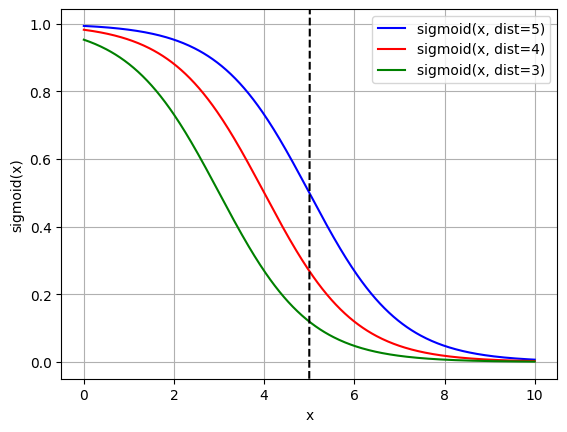

In [7]:
#funzione sigmoide per modificare la matrice delle distanze
def sigmoid(x, dist=5):
    return 1/(1+np.exp(x-dist))

# Crea un intervallo di x, ad esempio da -10 a 10
x_values = np.linspace(0, 10, 400)
# Calcola i valori della sigmoide per ogni x
sigmoid_5 = sigmoid(x_values, dist=5)
sigmoid_4 = sigmoid(x_values, dist=4)
sigmoid_3 = sigmoid(x_values, dist=3)
# Crea il grafico
plt.plot(x_values, sigmoid_5, label="sigmoid(x, dist=5)", color='b')
plt.plot(x_values, sigmoid_4, label="sigmoid(x, dist=4)", color='r')
plt.plot(x_values, sigmoid_3, label="sigmoid(x, dist=3)", color='g')
plt.axline(xy1=(5,0),slope=90,color='black', ls='--')

# Aggiungi etichette agli assi e un titolo
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
# Aggiungi una legenda
plt.legend()
# Mostra il grafico
plt.grid(True)
plt.show()


pos = 31


Text(0, 0.5, 'Embedding Value (Sum)')

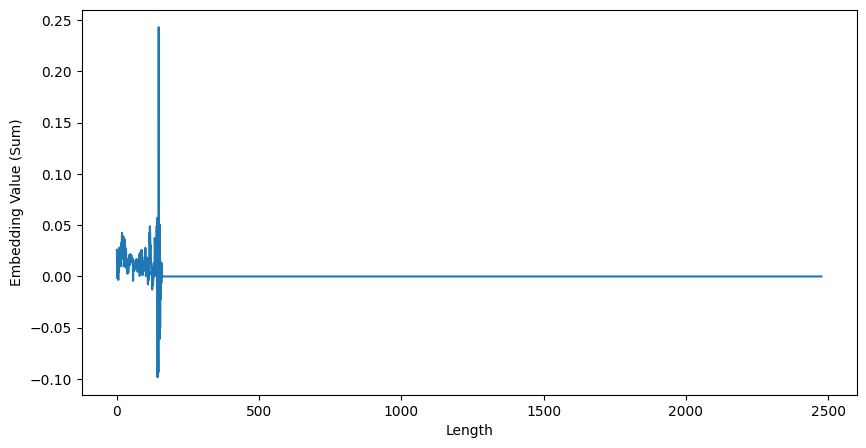

In [8]:
#embedding

# Ottieni un iteratore dal DataLoader
data_iter = iter(dataloader_train)
# Ottieni il primo batch
batch = next(data_iter)
plt.figure(figsize=(10,5))
sns.lineplot(batch['wild_type'][0,:,:].sum(dim=1) - batch['mut_type'][0,:,:].sum(dim=1) )
#plt.axline(xy1=(batch['pos_mut'][0], 0), slope=90, color='red', linestyle='--')
pos = 31
print(f'{pos = }')
plt.xlabel('Length')
plt.ylabel('Embedding Value (Sum)')

In [9]:
import copy

def output_model_from_batch(batch, model, device, train=True):

    '''Dato un modello pytorch e batch restituisce: output_modello, True labels'''
    
    x_wild = batch['wild_type'].float().to(device)
    x_mut = batch['mut_type'].float().to(device)
    labels = batch['ddg'].float().to(device)
    length = batch['length'].to(device)
    # try:
    #     hydra_slim = batch['hydra_slim'].to(device)
    #     output_ddg = model(x_wild, x_mut, length,hydra_slim=hydra_slim, train = train)
    # except:
        
        
    output_ddg = model(x_wild, x_mut, length, train = train)
    
    return output_ddg, labels


# def output_model_from_batch_HYDRA_SLIM(batch, model, device, train=True):

#     '''Dato un modello pytorch e batch restituisce: output_modello, True labels'''
    
#     x_wild = batch['wild_type'].float().to(device)
#     x_mut = batch['mut_type'].float().to(device)
#     length = batch['length'].to(device)

#     hydra_slim = batch['hydra_slim'].float().to(device)
#     output_ddg = model(x_wild, x_mut, length, train = train)

#     HYDRA1 = model(x_wild, hydra_slim, length, train = train)
#     HYDRA2 = model(hydra_slim, x_mut, length, train = train)
#     HYDRA_TOT = HYDRA1+HYDRA2
    
#     return HYDRA_TOT, output_ddg


def training_and_validation_loop_ddg(model, dataloader_train, dataloader_test, dataloader_validation, path_save_fig, epochs=20, lr =0.001, patience=10):
            
    criterion =nn.MSELoss()# nn.HuberLoss()#nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    pearson_r_train = []
    pearson_r_test = []
    #pearson_r_test_inv =[]
    pearson_r_validation = []
    
    loss_ddg_train = []
    loss_ddg_test = []
    loss_ddg_validation = []

    num_epochs = epochs
    for epoch in range(num_epochs):
            
        # Training Loop
        model.train()
        preds_ddg_train = []
        preds_dgw_train = []
        preds_dgm_train = []
        preds_coerenza_train = []

        labels_tot_epoch = []

        for i, batch in enumerate(dataloader_train):
            train = True
            
            optimizer.zero_grad()
            output_ddg, labels = output_model_from_batch(batch, model, device, train=train)

            # output_ddg_HYDRA_SLIM, labels_HYDRA_SLIM = output_model_from_batch_HYDRA_SLIM(batch, model, device, train=train)
            
            
            if isinstance(output_ddg, list):
                # Compute the loss for each output and sum them
                loss_list = [criterion(output_aa, labels) for output_aa in output_ddg]
                loss_ddg = torch.stack(loss_list).sum()
                output_ddg  = torch.mean(torch.stack(output_ddg), dim=0)
            else: 
                loss_ddg = criterion(output_ddg, labels)  #usa se NON uso hydra
            
            tot_loss = loss_ddg 
            
            # Backpropagation and optimization
            tot_loss.backward()
            optimizer.step()

            # Collect predictions
            preds_ddg_train.extend(output_ddg.cpu().reshape(-1).tolist())
            labels_tot_epoch.extend(labels.cpu().tolist())

        # Calculate and print train metrics
        train_loss = mean_squared_error(preds_ddg_train, labels_tot_epoch)
        train_correlation = pearsonr(preds_ddg_train, labels_tot_epoch)[0]
        train_spearman = spearmanr(preds_ddg_train, labels_tot_epoch)[0]
        
        loss_ddg_train.append(train_loss)
        pearson_r_train.append(train_correlation)
        
        # Validation Loop
        model.eval()  # Set model to evaluation mode
                
        all_preds_validation = []
        all_labels_validation = []
        all_preds_test = []
        all_labels_test = []
      
        
        with torch.no_grad():  # Disable gradient calculation
            train = False
            for i, batch in enumerate(dataloader_test):

                output_ddg,labels = output_model_from_batch(batch, model, device, train=train) 
                    
                all_preds_test.extend(output_ddg.cpu().reshape(-1).tolist())
                all_labels_test.extend(labels.cpu().tolist())
            
            # Calculate validation metrics
            test_loss = mean_squared_error(all_preds_test, all_labels_test)
            loss_ddg_test.append(test_loss)
            
            test_correlation, _ = pearsonr(all_preds_test, all_labels_test)
            pearson_r_test.append(test_correlation)

            for i, batch in enumerate(dataloader_validation):
                output_ddg,labels = output_model_from_batch(batch, model, device, train=train)

                all_preds_validation.extend(output_ddg.cpu().reshape(-1).tolist())
                all_labels_validation.extend([x for x in labels.cpu().tolist()]) #MESSO UN -  se DEF AL CONTRARIO
            
            # Calculate validation metrics
            val_loss = mean_squared_error(all_preds_validation, all_labels_validation)
            loss_ddg_validation.append(val_loss)
            
            val_correlation, _ = pearsonr(all_preds_validation, all_labels_validation)
            pearson_r_validation.append(val_correlation)

        
        if val_correlation >= max(pearson_r_validation): 
            best_model = copy.deepcopy(model)
            print(f'\033[91mEpoch {epoch+1}/{num_epochs}')
            print(f'Train -      Loss: {train_loss:.4f}, Pearson r: {train_correlation:.4f}, Rho spearman: {train_spearman:.4f}')
            print(f'Validation - Loss: {val_loss:.4f}, Pearson r: {val_correlation:.4f}, Rho spearman: {spearmanr(all_preds_validation, all_labels_validation)[0]:.4f}',)        
            print(f'Test -       Loss: {test_loss:.4f}, Pearson r: {test_correlation:.4f}, Rho spearman: {spearmanr(all_preds_test, all_labels_test)[0]:.4f}\033[0m\n')
      

        else:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train -      Loss: {train_loss:.4f}, Pearson r: {train_correlation:.4f}, Rho spearman: {train_spearman:.4f}')
            print(f'Validation - Loss: {val_loss:.4f}, Pearson r: {val_correlation:.4f}, Rho spearman: {spearmanr(all_preds_validation, all_labels_validation)[0]:.4f}',)        
            print(f'Test -       Loss: {test_loss:.4f}, Pearson r: {test_correlation:.4f}, Rho spearman: {spearmanr(all_preds_test, all_labels_test)[0]:.4f}\n')
                  
        if epoch > (np.argmax(pearson_r_validation) + patience):
            print(f'\033[91mEarly stopping at epoch {epoch+1}\033[0m')
            break

        # if (epoch == 100) or (epoch == 150) or (epoch == 200) or (epoch == 250) or (epoch == 300):
        #     torch.save(model, f'JanusDDG_{epoch}_ensamble.pth')
    
    pearson_max_val = np.max(pearson_r_validation)

    return pearson_r_train, pearson_r_validation, pearson_r_test, loss_ddg_train, loss_ddg_validation, loss_ddg_test, pearson_max_val, best_model

In [10]:
class Cross_Attention_DDG(nn.Module):
    
    def __init__(self, base_module, cross_att=False, dual_cross_att= False,**transf_parameters):
        super().__init__()
        self.base_ddg = base_module(**transf_parameters, cross_att=cross_att, dual_cross_att= dual_cross_att).to(device)
    
    def forward(self, x_wild, x_mut,length, hydra_slim=None, train = True):

        delta_x_dir = x_wild - x_mut
        output_TCA_dir = self.base_ddg(delta_x_dir, x_wild, length)
    
        # delta_x_inv = x_mut - x_wild
        # output_TCA_inv = self.base_ddg(delta_x_inv, x_mut, length) #PROVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
            
            
        return output_TCA_dir #(output_TCA_dir-output_TCA_inv)/2


In [11]:
import torch
import torch.nn as nn


def apply_masked_pooling(position_attn_output, padding_mask):

    # Convert mask to float for element-wise multiplication
    padding_mask = padding_mask.float()

    # Global Average Pooling (GAP) - Exclude padded tokens
    # Sum only over valid positions (padding_mask is False for valid positions)
    sum_output = torch.sum(position_attn_output * (1 - padding_mask.unsqueeze(-1)), dim=1)  # (batch_size, feature_dim)
    valid_count = torch.sum((1 - padding_mask).float(), dim=1)  # (batch_size,)
    gap = sum_output / valid_count.unsqueeze(-1)  # Divide by number of valid positions

    # Global Max Pooling (GMP) - Exclude padded tokens
    # Set padded positions to -inf so they don't affect the max computation
    position_attn_output_masked = position_attn_output * (1 - padding_mask.unsqueeze(-1)) + (padding_mask.unsqueeze(-1) * (- 1e10))
    gmp, _ = torch.max(position_attn_output_masked, dim=1)  # (batch_size, feature_dim)

    return gap, gmp


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=3700):
        super(SinusoidalPositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)  # Salvato come tensore fisso (non parametro)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class TransformerRegression(nn.Module):
    def __init__(self, input_dim=1280, num_heads=8, dropout_rate=0., num_experts=1, f_activation = nn.ReLU(), kernel_size=20, cross_att = True,
                dual_cross_att=True):
        
        super(TransformerRegression, self).__init__()

        self.embedding_dim = input_dim
        self.act = f_activation
        self.max_len = 3700 #lunghezza massima proteina
        out_channels = 128  #num filtri conv 1D
        kernel_size = 20
        padding = 0
        
        self.conv1d = nn.Conv1d(in_channels=self.embedding_dim, 
                                             out_channels=out_channels, 
                                             kernel_size=kernel_size, 
                                             padding=padding) 
        
        self.conv1d_wild = nn.Conv1d(in_channels=self.embedding_dim, 
                                             out_channels=out_channels, 
                                             kernel_size=kernel_size, 
                                             padding=padding)

        self.norm1 = nn.LayerNorm(out_channels)
        self.norm2 = nn.LayerNorm(out_channels)
        
        # Cross-attention layers
        self.positional_encoding = SinusoidalPositionalEncoding(out_channels, 3700)
        self.speach_att_type = True
        self.multihead_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, dropout=dropout_rate, batch_first=True )
        self.inverse_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, dropout=dropout_rate, batch_first =True)
        
        dim_position_wise_FFN = out_channels*2

        self.norm3 = nn.LayerNorm(dim_position_wise_FFN)
        self.router = nn.Linear(dim_position_wise_FFN, num_experts) #dim_position_wise_FFN*2

        self.pw_ffnn = nn.Sequential(
            nn.Linear(dim_position_wise_FFN, 512),
            self.act,
            nn.Linear(512, dim_position_wise_FFN)
            )
        

        self.Linear_ddg = nn.Linear(dim_position_wise_FFN*2, 1)

            

    def create_padding_mask(self, length, seq_len, batch_size):
        """
        Create a padding mask for multihead attention.
        length: Tensor of shape (batch_size,) containing the actual lengths of the sequences.
        seq_len: The maximum sequence length.
        batch_size: The number of sequences in the batch.
        
        Returns a padding mask of shape (batch_size, seq_len).
        """
        mask = torch.arange(seq_len, device=length.device).unsqueeze(0) >= length.unsqueeze(1)
        return mask



    def forward(self, delta_w_m, x_wild, length):
            
            delta_w_m = delta_w_m.transpose(1, 2)  # (batch_size, feature_dim, seq_len) -> (seq_len, batch_size, feature_dim)
            C_delta_w_m = self.conv1d(delta_w_m)
            C_delta_w_m = C_delta_w_m.transpose(1, 2)  # (seq_len, batch_size, feature_dim) -> (batch_size, seq_len, feature_dim)
            C_delta_w_m = self.positional_encoding(C_delta_w_m)
            
            x_wild = x_wild.transpose(1, 2)  # (batch_size, feature_dim, seq_len) -> (seq_len, batch_size, feature_dim)
            C_x_wild = self.conv1d_wild(x_wild)
            C_x_wild = C_x_wild.transpose(1, 2)  # (seq_len, batch_size, feature_dim) -> (batch_size, seq_len, feature_dim)
            C_x_wild = self.positional_encoding(C_x_wild)            
            
            batch_size, seq_len, feature_dim = C_x_wild.size()

            padding_mask = self.create_padding_mask(length, seq_len, batch_size)        
                    
            if self.speach_att_type:
                print('ATTENTION TYPE: Dual cross Attention\n q = wild , k = delta, v = delta and q = delta , k = wild, v = wild \n ----------------------------------')
                self.speach_att_type = False
                
            direct_attn_output, _ = self.multihead_attention(C_x_wild, C_delta_w_m, C_delta_w_m, key_padding_mask=padding_mask)
            direct_attn_output += C_delta_w_m 
            direct_attn_output = self.norm1(direct_attn_output)                        
            
            inverse_attn_output, _ = self.inverse_attention(C_delta_w_m, C_x_wild, C_x_wild, key_padding_mask=padding_mask)                   
            inverse_attn_output += C_x_wild  
            inverse_attn_output = self.norm2(inverse_attn_output)
            
            attn_output = torch.cat([direct_attn_output, inverse_attn_output], dim=-1)

            output = self.pw_ffnn(attn_output)
    
            position_attn_output = attn_output + output
    
            position_attn_output = self.norm3(position_attn_output)
    
            gap, gmp = apply_masked_pooling(position_attn_output, padding_mask)
    
            # Concatenate GAP and GMP
            pooled_output = torch.cat([gap, gmp], dim=-1)  # (batch_size, 2 * feature_dim)
    
            # Pass through FFNN to predict DDG
            x = self.Linear_ddg(pooled_output)        
            
            return x.squeeze(-1)

In [12]:
assert False

AssertionError: 

In [13]:
#PROVA base base
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 1e-4
input_dim = 1280

transf_parameters={'input_dim':1280, 'num_heads':8,
                    'dropout_rate':0.,}

patience = 300
DDG_model = TransformerRegression
Final_model = Cross_Attention_DDG(DDG_model, cross_att = True, dual_cross_att=True, **transf_parameters)

path_save_fig = 'DDGemb \n ----------------------------------'
print(path_save_fig)
p_tr,p_val, p_te, l_tr,l_val, l_te, pearson_max_val, best_model = training_and_validation_loop_ddg(Final_model, dataloader_train, dataloader_test,
                                                                                   dataloader_validation,
                                                                                   path_save_fig, epochs=300, lr =lr,patience = patience)

DDGemb 
 ----------------------------------
ATTENTION TYPE: Dual cross Attention
 q = wild , k = delta, v = delta and q = delta , k = wild, v = wild 
 ----------------------------------
Epoch 1/300
Train -      Loss: 1.8881, Pearson r: 0.6380, Rho spearman: 0.6373
Validation - Loss: 4.7021, Pearson r: 0.5590, Rho spearman: 0.4886
Test -       Loss: 2.3662, Pearson r: 0.5075, Rho spearman: 0.5273

Epoch 2/300
Train -      Loss: 1.1301, Pearson r: 0.8035, Rho spearman: 0.7935
Validation - Loss: 4.6910, Pearson r: 0.5548, Rho spearman: 0.5308
Test -       Loss: 1.9932, Pearson r: 0.5073, Rho spearman: 0.5099

Epoch 3/300
Train -      Loss: 0.7244, Pearson r: 0.8791, Rho spearman: 0.8684
Validation - Loss: 4.5552, Pearson r: 0.5702, Rho spearman: 0.5547
Test -       Loss: 1.9255, Pearson r: 0.5208, Rho spearman: 0.5209

Epoch 4/300
Train -      Loss: 0.4434, Pearson r: 0.9279, Rho spearman: 0.9228
Validation - Loss: 4.9797, Pearson r: 0.5280, Rho spearman: 0.5389
Test -       Loss: 2.0201,

In [14]:
Final_model.state_dict()

OrderedDict([('base_ddg.conv1d.weight',
              tensor([[[ 3.7088e-02,  1.9108e-02,  1.6996e-02,  ...,  3.9826e-02,
                         3.5682e-03,  5.5280e-02],
                       [ 6.3159e-02, -1.8141e-02,  1.1711e-02,  ...,  4.7014e-02,
                         8.5385e-03, -1.0180e-02],
                       [ 1.3502e-02,  5.9901e-02,  1.7355e-02,  ..., -1.4850e-02,
                         3.8437e-02, -9.4598e-02],
                       ...,
                       [-2.0559e-02, -9.6466e-04,  4.2317e-03,  ..., -2.2692e-02,
                         2.2367e-02,  6.7275e-02],
                       [ 7.1387e-02,  5.3270e-02,  3.5843e-02,  ...,  1.4182e-02,
                         3.0170e-02, -3.5793e-03],
                       [ 1.6414e-02,  3.4843e-02,  6.6215e-02,  ..., -5.1677e-02,
                         2.6038e-02,  2.0384e-02]],
              
                      [[-1.0834e-01, -4.9843e-02,  2.6710e-02,  ..., -3.2249e-02,
                         3.1481e-02,

In [ ]:

##  MODELLO PER MULTIPLE
#train_path =[f's2450_fold_{i}.pkl' for i in [0,1,2,3,4]]+[f's2450_fold_{i}_inv.pkl' for i in [0,1,2,3,4]] + ['ptmul_train.pkl']+['DA_s2450.pkl']#



#PROVA A USARE SOLO DA_MULTIPLE_2450 DA FARE IL DATASET...


##############

#JANUS300 EPOCHS

# Epoch 1/300
# Train -      Loss: 1.8881, Pearson r: 0.6380, Rho spearman: 0.6373
# Validation - Loss: 2.3668, Pearson r: 0.5073, Rho spearman: 0.5271
# Test -       Loss: 2.3662, Pearson r: 0.5075, Rho spearman: 0.5273

# Epoch 2/300
# Train -      Loss: 1.1301, Pearson r: 0.8035, Rho spearman: 0.7935
# Validation - Loss: 1.9912, Pearson r: 0.5080, Rho spearman: 0.5103
# Test -       Loss: 1.9932, Pearson r: 0.5073, Rho spearman: 0.5099

# Epoch 3/300
# Train -      Loss: 0.7244, Pearson r: 0.8791, Rho spearman: 0.8684
# Validation - Loss: 1.9245, Pearson r: 0.5210, Rho spearman: 0.5209
# Test -       Loss: 1.9255, Pearson r: 0.5208, Rho spearman: 0.5209


#ARRIVA A 55

#################



#s2450 +s2450inv+ ptmul_train : 

# Epoch 111/300
# Train -      Loss: 0.0096, Pearson r: 0.9987, Rho spearman: 0.9984
# Validation - Loss: 4.6144, Pearson r: 0.5621, Rho spearman: 0.5345
# Test -       Loss: 1.9337, Pearson r: 0.5208, Rho spearman: 0.5338

# Epoch 112/300
# Train -      Loss: 0.0107, Pearson r: 0.9985, Rho spearman: 0.9983
# Validation - Loss: 4.6020, Pearson r: 0.5630, Rho spearman: 0.5403
# Test -       Loss: 1.9419, Pearson r: 0.5208, Rho spearman: 0.5367

##############################################################################

train con hydra
# Epoch 145/300
# Train -      Loss: 0.0034, Pearson r: 0.9995, Rho spearman: 0.9995
# Validation - Loss: 0.9176, Pearson r: 0.8205, Rho spearman: 0.8206
# Test -       Loss: 2.0290, Pearson r: 0.5171, Rho spearman: 0.5325

# Epoch 146/300
# Train -      Loss: 0.0040, Pearson r: 0.9994, Rho spearman: 0.9994
# Validation - Loss: 0.9274, Pearson r: 0.8196, Rho spearman: 0.8189
# Test -       Loss: 2.0288, Pearson r: 0.5173, Rho spearman: 0.5318

In [15]:
torch.save(Final_model, 'JanusDDG_300epochs_ARXIVE.pth')

In [ ]:
#torch.save(best_model, 'DDGemb_Cross_0.pth')

In [ ]:
#torch.save(Final_model, 'JanusDDG_300epochs_plus25_hydra_slim.pth')

In [ ]:
torch.save(Final_model, 'JanusDDG_300epochs_plus25_hydra_slim_plus20_double.pth')

In [ ]:
#torch.save(Final_model, 'JanusDDG_300_all_train.pth') #window 20 

In [ ]:
#torch.save(Final_model, 'CHECKJANUS_multiple.pth')

In [ ]:
assert False

In [ ]:
import torch

# Lista dei file dei modelli salvati
model_paths = [f'JanusDDG_{epoch}_ensamble.pth' for epoch in range(100, 301,50)]

# Carica gli state_dict dei modelli
state_dicts = [torch.load(path).state_dict() for path in model_paths]

# Crea un nuovo state_dict per il modello mediato
avg_state_dict = {}

# Itera su tutti i parametri del modello
for key in state_dicts[0]:  # Prendi le chiavi dal primo modello
    avg_state_dict[key] = sum(d[key] for d in state_dicts) / len(state_dicts)

# Carica i pesi mediati in un nuovo modello
final_model = torch.load(model_paths[0])  # Carica uno dei modelli per l'architettura
final_model.load_state_dict(avg_state_dict)

# Salva il modello mediato
torch.save(final_model, "JanusDDG_avg_final.pth")

In [ ]:

con 

#SENZA RELU NELLA CONV1D
# lr = 1e-4
# input_dim = 1280

# transf_parameters={'input_dim':1280, 'num_heads':8,
#                     'dropout_rate':0.,}
# arrivo a 0.54  (dopo un po' meno di 200 epoche)


#     def __init__(self, input_dim=1280, num_heads=8, dropout_rate=0., num_experts=1, f_activation = nn.ReLU(), kernel_size=15, cross_att = False,
#                 dual_cross_att=False):
        
#         super(TransformerRegression, self).__init__()
#         self.cross_att = cross_att
#         self.dual_cross_att = dual_cross_att
        
#         print(f'Cross Attention: {cross_att}')
#         print(f'Dual Cross Attention: {dual_cross_att}')

#         self.embedding_dim = input_dim
#         self.act = f_activation
#         self.max_len = 3700 #lunghezza massima proteina
#         out_channels = 128  #num filtri conv 1D
#         kernel_size = 20
#         padding = 0



In [ ]:
# import pickle
# with open("JanusDDG_loss_train.pkl", "wb") as f:
#     pickle.dump(l_tr, f)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Primo sottografico: Pearson r per il set di Train
sns.lineplot(data=p_tr, ax=axes[0], label='Train r')
#sns.lineplot(data=p_val, ax=axes[0], label='Test r')
sns.lineplot(data=p_te, ax=axes[0], label='Test r')

axes[0].legend()
axes[0].set_title('Pearson r Values for Train and Test Set')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Pearson r')
#axes[0].text(10, 0.53, str(round(pearson_max_val,3)), fontsize=12, color='red')
axes[0].text(10, 0.53, str(round(max(p_te),3)), fontsize=12, color='red')

axes[0].axhline(y=0.545, color='r', linestyle='--', linewidth=2)

# Secondo sottografico: Pearson r per il set di Test
sns.lineplot(data=l_tr, ax=axes[1], label='Train Loss')
sns.lineplot(data=l_te, ax=axes[1], label='Test Loss')

axes[1].legend()
axes[1].set_title('Loss Values for Train and Test Set')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Huber Loss')

# Imposta il titolo generale per la figura
fig.suptitle('JanusDDG Pearson r Values for Train and Test Sets', fontsize=16)

In [ ]:
assert False

In [ ]:
def metrics(pred_dir, pred_inv, true):

    #Dirette
    print(f'Pearson test dirette: {pearsonr(true,pred_dir)[0]}')   
    print(f'Spearmanr test dirette: {spearmanr(true,pred_dir)[0]}')    
    print(f'RMSE dirette: {root_mean_squared_error(true,pred_dir)}')
    print(f'MAE dirette: {mean_absolute_error(true,pred_dir)}\n')
    
    #Inverse
    print(f'Pearson test inverse: {pearsonr(-true,pred_inv)[0]}')   
    print(f'Spearmanr test inverse: {spearmanr(-true,pred_inv)[0]}')    
    print(f'RMSE inverse: {root_mean_squared_error(-true,pred_inv)}')
    print(f'MAE inverse: {mean_absolute_error(-true,pred_inv)}\n')
    #Tot
    
    print(f'Pearson test tot: {pearsonr(pd.concat([true,-true],axis=0),pd.concat([pred_dir,pred_inv],axis=0))[0]}')   
    print(f'Spearmanr test tot: {spearmanr(pd.concat([true,-true],axis=0),pd.concat([pred_dir,pred_inv],axis=0))[0]}')    
    print(f'RMSE tot: {root_mean_squared_error(pd.concat([true,-true],axis=0),pd.concat([pred_dir,pred_inv],axis=0))}')
    print(f'MAE tot: {mean_absolute_error(pd.concat([true,-true],axis=0),pd.concat([pred_dir,pred_inv],axis=0))}\n')
    
    print(f'PCC d-r: {pearsonr(pred_dir,pred_inv)}\n')
    print(f'anti-symmetry bias: {np.mean(pred_dir + pred_inv)}\n-----------------------\n')


In [ ]:
# def output_model_from_batch_inv(batch, model, device, train=True):

#     '''Dato un modello pytorch e batch restituisce: output_modello, True labels'''
    
#     x_wild = batch['mut_type'].float().to(device)
#     x_mut = batch['wild_type'].float().to(device)
#     labels = -batch['ddg'].float().to(device)
#     length = batch['length'].to(device)
#     output_ddg = model(x_wild, x_mut, length, train = train)
    
#     return output_ddg, labels

In [ ]:
def dataloader_generation_pred(E_TYPE, test_path, batch_size = 128, dataloader_shuffle = True, inv= False):
    
    EMBEDDING_TYPE = E_TYPE
    
    if EMBEDDING_TYPE == 'ESM2':

        '''train formato da s2648 + UnionV e DA; 1000 dei DA sono usati nel validation insieme a s669 DA
        '''
        
        dim_embedding = 1280
        
        dataset_test = []
        
        for path in test_path:           
            with open(path, 'rb') as f:
                dataset_test += pickle.load(f)
    
    else:
        assert False

    dataset_test = DeltaDataset(dataset_test, dim_embedding, inv = inv)
    
    # Creazione DataLoader
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=dataloader_shuffle, collate_fn=collate_fn)#collate_fn_MULTIPLE

    return dataloader_test


In [ ]:

# def collate_fn_MULTIPLE(batch):
#     max_len = max(sample['wild_type'].shape[0] for sample in batch)  # Max sequence length in batch   700
#     max_features = max(sample['wild_type'].shape[1] for sample in batch)  # Max feature size

#     padded_batch = {
#         'id': [],
#         'wild_type': [],
#         'mut_type': [],
#         'length': [],
#         'ddg': [],
#         #'alpha_vec': [],
#         'pos_mut': []
#     }

#     for sample in batch:
#         wild_type_padded = F.pad(sample['wild_type'], (0, max_features - sample['wild_type'].shape[1], 
#                                                        0, max_len - sample['wild_type'].shape[0]))
#         mut_type_padded = F.pad(sample['mut_type'], (0, max_features - sample['mut_type'].shape[1], 
#                                                      0, max_len - sample['mut_type'].shape[0]))

#         padded_batch['id'].append(sample['id'])  
#         padded_batch['wild_type'].append(wild_type_padded)  
#         padded_batch['mut_type'].append(mut_type_padded)  
#         padded_batch['length'].append(sample['length'])#append(torch.tensor(sample['length'], dtype=torch.float32))  
#         padded_batch['ddg'].append(sample['ddg'])#append(torch.tensor(float(sample['ddg']), dtype=torch.float32))  
#         #padded_batch['alpha_vec'].append(sample['alpha_vec'])#append(torch.tensor(sample['alpha_vec'], dtype=torch.float32))  
#         #padded_batch['pos_mut'].append(sample['pos_mut'])#append(torch.tensor(sample['pos_mut'], dtype=torch.int64))  

#     # Convert list of tensors into a single batch tensor
#     padded_batch['wild_type'] = torch.stack(padded_batch['wild_type'])  # Shape: (batch_size, max_len, max_features)
#     padded_batch['mut_type'] = torch.stack(padded_batch['mut_type'])  
#     padded_batch['length'] = torch.stack(padded_batch['length'])  
#     padded_batch['ddg'] = torch.stack(padded_batch['ddg'])  
#     #padded_batch['alpha_vec'] = torch.stack(padded_batch['alpha_vec'])  
#     #padded_batch['pos_mut'] = torch.stack(padded_batch['pos_mut'])  

#     return padded_batch



In [ ]:
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
E_TYPE = 'ESM2'
dataloader_test = dataloader_generation_pred(E_TYPE,  test_path=['s669_Castrense.pkl'],  batch_size = 6, dataloader_shuffle = False, inv= False)
#['s669_Castrense.pkl']#'PTMUL_D.pkl'
#'ddg_S2648_ESM2_ALL_LENGTH.pkl' #'s2450_fold_4.pkl' 
#['../DeltaDelta_BELLO/cdna117k_fold_1.pkl'] + ['../DeltaDelta_BELLO/cdna117k_fold_2.pkl']

In [ ]:
# test model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_performance_test(model, dataloader_test, inv= False, train = False):
    # Assicurati che il modello sia in modalità di valutazione
    model.eval()
    
    # Lista per salvare tutte le predizioni
    all_predictions_test = []
    all_lables_test = []
    
    with torch.no_grad():  # Disable gradient calculation
       
        for i, batch in enumerate(dataloader_test):

            predictions_test, labels_test=output_model_from_batch(batch, model, device, train=False)

            # Aggiungi le predizioni alla lista
            all_predictions_test.append(predictions_test)
            all_lables_test.append(labels_test)

    return all_predictions_test, all_lables_test

In [ ]:
lr = 1e-4
input_dim = 1280

transf_parameters={'input_dim':1280, 'num_heads':8,
                    'dropout_rate':0.,}
i=4
best_model = torch.load('JanusDDG_300epochs.pth')#(f'JanusDDG_300epochs.pth')
#torch.load(f'DDGemb_Cross_4.pth')

In [ ]:
all_predictions_test, all_lables_test = model_performance_test(best_model,dataloader_test,
                                                          inv=False, train=False)

In [ ]:
print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), -torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(),- torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(),- torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
pearsonr(torch.cat(all_predictions_test, dim=0).cpu()[:669],torch.cat(all_predictions_test, dim=0).cpu()[669:])

In [ ]:
(torch.cat(all_predictions_test, dim=0).cpu()[:669] + torch.cat(all_predictions_test, dim=0).cpu()[669:]).mean()

In [ ]:
#pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('DDGemb_cross_0_predictions.pkl')

In [ ]:
pd.read_pickle('indici_ordinati_s669.pkl').sort_values(by='index_castrense')['DDG'].values

In [ ]:
indici_ordinati = pd.read_pickle('indici_ordinati_s669.pkl').sort_values(by='index_castrense')['index'].values
pythia_s669 = pd.read_csv('../DeltaDeltaG/pythia_s669.csv').iloc[indici_ordinati,:]['Pythia_inv']
info_mut = pd.read_csv('../DeltaDeltaG/pythia_s669.csv').iloc[indici_ordinati,:][['wildtype','mutation']]
pred_janus= np.array(torch.cat(all_predictions_test, dim=0).cpu())
true_ddg = pd.read_pickle('indici_ordinati_s669.pkl').sort_values(by='index_castrense')['DDG'].values#np.array(torch.cat(all_lables_test, dim=0).cpu())

df = pd.DataFrame({
    'wild':info_mut.iloc[:,0].values,
    'mut':info_mut.iloc[:,1].values,
    'pythia_s669': pythia_s669.values,  # Deve avere la stessa lunghezza di predictions
    'predictions': pred_janus,  # Ogni riga avrà un valore scalare o un array se multidimensionale
    'true_ddg':true_ddg
})
df.index = indici_ordinati
print('Pearson s669: ', pearsonr(df['predictions'],df['true_ddg']))   


indici_ordinati_s461  = pd.read_pickle('indici_ordinati_s669.pkl').dropna(subset='s461_pdb').sort_values(by='index_castrense')['index'].values



In [ ]:
rose_csv = pd.read_csv('rose1985.csv')

def rose_score(row):
    wild_rose = rose_csv[rose_csv['Parameter']==row['wild']]['Rose1985'].values[0]
    mut_rose = rose_csv[rose_csv['Parameter']==row['mut']]['Rose1985'].values[0]
    return wild_rose - mut_rose
    
df['Rose'] = df.apply(rose_score,axis=1)
df

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)

lr.fit(df[['pythia_s669','Rose']].values,df['true_ddg'].values)
pearsonr(lr.predict(df[['pythia_s669','Rose']].values),df['true_ddg'].values)



In [ ]:
pearsonr(df['pythia_s669'].values * 0.11 - df['Rose'].values*0.0088,df['true_ddg'].values)


In [ ]:
df_s461 = df.loc[indici_ordinati_s461,:]

In [ ]:
print(pearsonr(df_s461['pythia_s669']*0.11-df_s461['Rose']*0.0088 ,df_s461['true_ddg']))   
print(pearsonr(df_s461['predictions'],df_s461['true_ddg']))   
print('RMSE: ', root_mean_squared_error(df_s461['pythia_s669'],df_s461['true_ddg']))
print('MAE: ', mean_squared_error(df_s461['pythia_s669'],df_s461['true_ddg']))



In [ ]:
df

In [ ]:
print(pearsonr(df_s461['predictions'],df_s461['true_ddg']))   
print(pearsonr(df['predictions'],df['true_ddg']))   


In [ ]:
print(f'Pearson test dirette: {pearsonr(-0.07416111+ pythia_s669.values*0.09+np.array(torch.cat(all_predictions_test, dim=0).cpu()*0.57), torch.cat(all_lables_test, dim=0).cpu())}')   


In [ ]:
pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('Janus_s669_fake.pkl')

In [ ]:
dir = torch.cat(all_predictions_test, dim=0).cpu()

In [ ]:
inv = torch.cat(all_predictions_test, dim=0).cpu()


In [ ]:
tot =(dir-inv) /2

In [ ]:
tot

In [ ]:
metrics( pd.DataFrame(tot),  pd.DataFrame(tot), pd.DataFrame(torch.cat(all_lables_test, dim=0).cpu()))

In [ ]:
pred_inv = all_predictions_test

In [ ]:
pred_dirette = all_predictions_test
true = all_lables_test

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

metrics( pd.DataFrame(torch.cat(pred_dirette, dim=0).cpu()), pd.DataFrame(torch.cat(pred_inv, dim=0).cpu()), pd.DataFrame(torch.cat(true, dim=0).cpu()))

In [ ]:
50+49+53+51+51

In [ ]:
for i in range(5):
    val_Set = [0,1,2,3,4]
    val_Set.remove(i)
    print(val_Set)
    best_model = torch.load(f'DDGemb_Cross_{i}.pth')
    
    dataloader_val = dataloader_generation_pred(E_TYPE,  test_path=[f's2450_fold_{i}.pkl']+[f's2450_fold_{i}_inv.pkl'],
                                                 batch_size = 6, dataloader_shuffle = False, inv= False)
    
    all_predictions_val, all_lables_val = model_performance_test(best_model,dataloader_val,
                                                              inv=False, train=False)
    
    
    print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_val, dim=0).cpu(), torch.cat(all_lables_val, dim=0).cpu())}')   


In [ ]:
pesi = np.array([0.2,0.21,0.2,0.19,0.2])

In [ ]:
pred_tot = []

for i in range(5):
    best_model = torch.load(f'DDGemb_Cross_{i}.pth')
    
    all_predictions_test, all_lables_test = model_performance_test(best_model,dataloader_test,
                                                          inv=False, train=False)
    
    pred_tot.append(pd.Series(torch.cat(all_predictions_test, dim=0).cpu()))#.to_pickle('DDGemb_Cross_0_predictions_s669.pkl')

In [ ]:
pred_inv = pred_tot.copy()

In [ ]:
pred_dir = pred_tot.copy()

In [ ]:
pred_tot

In [ ]:
somma_pesata_dir = sum(w * v for w, v in zip(pesi, pred_tot))

print(somma_pesata)

In [ ]:
pesi

In [ ]:
somma_pesata_inv = sum(w * v for w, v in zip(pesi, pred_inv))


In [ ]:
r = pred_tot[0]+pred_tot[1]+pred_tot[2]+pred_tot[3]+pred_tot[4]

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
somma_pesata

In [ ]:
somma_pesata_inv

In [ ]:
metrics(pd.DataFrame(somma_pesata_dir),pd.DataFrame(somma_pesata_inv),-pd.DataFrame(torch.cat(all_lables_test, dim=0).cpu()))

In [ ]:
np.mean([386,342,187,497,105])

In [ ]:
best_model = torch.load(f'DDGemb_Cross_4.pth')
all_predictions_test, all_lables_test = model_performance(best_model,dataloader_test,
                                                          dataloader_train=None,dataloader_validation=None,inv=True, train=False)

pred_tot.append(pd.Series(torch.cat(all_predictions_test, dim=0).cpu()))#.to_pickle('DDGemb_Cross_0_predictions_s669.pkl')

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
#BOOTSTRAPPING

results_naive=[]
for i in range(1000):
    dataloader_test = dataloader_generation_pred(E_TYPE,  test_path='ddg_s669_ESM2_HYDRA_LITE.pkl',  batch_size = 128, dataloader_shuffle = False, inv= False)

    all_predictions_test, all_lables_test = model_performance(best_model,
                                                                                                                                           dataloader_test,
                                                                                                                                           dataloader_train=None,
                                                                                                                                           dataloader_validation=None,         
                                                                                                                                           inv=False,
                                                                                                                                           train=True)
    results_naive.append(pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())[0]) 

pd.DataFrame(results_naive).to_pickle('result_bootstrapping_MLP_27_01_2025.pkl')

In [ ]:
best_model = torch.load('MLP_HYDRA_MEAN_29_01_2025.pth')#('MLP_HYDRA_MEAN_29_01_2025.pth')#'MLP_27_01_2025.pth')#('MPL_HYDRA_model_7W_256_256.pth')
best_model.hydra=True
results_hydra=[]
for i in range(1000):
    dataloader_test = dataloader_generation_pred(E_TYPE,  test_path='ddg_s669_ESM2_HYDRA_LITE.pkl',  batch_size = 128, dataloader_shuffle = False, inv= False)

    all_predictions_test, all_lables_test = model_performance(best_model,
                                                                                                                                           dataloader_test,
                                                                                                                                           dataloader_train=None,
                                                                                                                                           dataloader_validation=None,         
                                                                                                                                           inv=False,
                                                                                                                                           train=True)
    results_hydra.append(pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())[0]) 

pd.DataFrame(results_hydra).to_pickle('result_bootstrapping_MLP_HYDRA_MEAN_29_01_2025.pkl')

In [ ]:
sns.histplot(results_hydra,kde=True,color='blue')
sns.histplot(results_naive,kde=True,color='red')
from scipy.stats import ks_2samp
ks_2samp(results_hydra,results_naive)

In [ ]:
sns.histplot(results_hydra,kde=True)
sns.histplot(results_naive,kde=True)
from scipy.stats import ks_2samp
ks_2samp(results_hydra,results_naive)

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
pd.Series(torch.cat(all_predictions_test, dim=0).cpu())

In [ ]:
#pd.Series(torch.cat(all_predictions_train, dim=0).cpu()).to_pickle('MLP_HYDRA_7W_256_256_predictions_esm2_train.pkl')
pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('MLP_HYDRA_MEAN_29_01_2025.pkl')
#pd.Series(torch.cat(all_predictions_validation, dim=0).cpu()).to_pickle('MLP_HYDRA_7W_256_256_predictions_esm2_val.pkl')
# pd.Series(torch.cat(all_lables_train, dim=0).cpu()).to_pickle('MLP_all_lables_train.pkl')
# pd.Series(torch.cat(all_lables_test, dim=0).cpu()).to_pickle('MLP_all_lables_test.pkl')
# pd.Series(torch.cat(all_lables_validation, dim=0).cpu()).to_pickle('MLP_all_lables_val.pkl')

In [ ]:
#####NOMI 
#'MLP_HYDRA_7W_256_256_predictions_esm2_train.pkl'


#####

In [ ]:
pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('MLP_HYDRA_7W_256_256_predictions_Protherm_Doubles_pdbnum_2.pkl')


In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test d-r: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_predictions_test_inv, dim=0).cpu())}') 

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')


# Pearson test dirette: PearsonRResult(statistic=0.49811210357961794, pvalue=3.0676935334080987e-43)
# Pearson test dirette: SignificanceResult(statistic=0.5209411003368696, pvalue=8.229743816346383e-48)
# RMSE dirette: 1.4306520223617554
# MAE dirette: 1.0020039081573486

# Pearson test dirette: PearsonRResult(statistic=0.4984754880369162, pvalue=2.6104865839652876e-43)
# Pearson test dirette: SignificanceResult(statistic=0.5219817530960136, pvalue=4.996030095808217e-48)
# RMSE dirette: 1.4335042238235474
# MAE dirette: 1.0032145977020264

In [ ]:
print(f'Pearson test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
print(f'Pearson test inverse: {pearsonr(torch.cat(all_predictions_test_inv, dim=0).cpu(), torch.cat(all_lables_test_inv, dim=0).cpu())}')    
print(f'RMSE inve: {root_mean_squared_error(torch.cat(all_predictions_test_inv, dim=0).cpu(), torch.cat(all_lables_test_inv, dim=0).cpu())}')
print(f'MAE inve: {mean_absolute_error(torch.cat(all_predictions_test_inv, dim=0).cpu(), torch.cat(all_lables_test_inv, dim=0).cpu())}')

In [ ]:
all_predictions_test.extend(all_predictions_test_inv)
all_lables_test.extend(all_lables_test_inv)
print(f'Pearson test dirette+inverse: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette+inverse: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette+inverse: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
all_predictions_test

In [ ]:
## 

In [ ]:
y_esm2_train = pd.read_pickle('MLP_all_predictions_esm2_s2648.pkl')
y_esm2_test = pd.read_pickle('MLP_all_predictions_esm2_s669.pkl')

y_ohe_train = pd.read_pickle('MLP_all_predictions_ohe_s2648.pkl')
y_ohe_test = pd.read_pickle('MLP_all_predictions_ohe_s669.pkl')

y_true_test = pd.DataFrame(torch.cat(all_lables_test, dim=0).cpu())
y_true_train = pd.DataFrame(torch.cat(all_lables_train, dim=0).cpu())

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = pd.concat([y_esm2_train,y_ohe_train],axis=1)
X_test = pd.concat([y_esm2_test,y_ohe_test],axis=1) 
y_train = y_true_train

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction_lr = lr.predict(X_test)

In [ ]:
prediction_lr.reshape(669).values.shape

In [ ]:
y_true_test

In [ ]:
# Assicurati che entrambe le variabili siano monodimensionali
y_true_test_flat = y_true_test.values.ravel()  # Oppure .flatten()
prediction_lr_flat = prediction_lr.reshape(669).ravel()  # Oppure np.squeeze()

print(f'Pearson test dirette: {pearsonr(y_true_test_flat, prediction_lr_flat)}')    
print(f'RMSE dirette: {root_mean_squared_error(y_true_test_flat, prediction_lr_flat)}')  
print(f'MAE dirette: {mean_absolute_error(y_true_test_flat, prediction_lr_flat)}')  

In [ ]:
print(f'Pearson test dirette: {pearsonr(y_true_test_flat, X_test.iloc[:,0])}')    
print(f'RMSE dirette: {root_mean_squared_error(y_true_test_flat, X_test.iloc[:,0])}')  
print(f'MAE dirette: {mean_absolute_error(y_true_test_flat, X_test.iloc[:,0])}')  

In [ ]:
#################FINE

In [ ]:
with open('ddg_s2648_ESM2.pkl', 'rb') as f:
    dataset_s2648 = pickle.load(f)

with open('ddg_s669_ESM2.pkl', 'rb') as f:
    dataset_s669 = pickle.load(f)

In [ ]:

# # Creiamo il dataset
dataset_train = ProteinDataset(dataset_s2648, threshold=5.0)
dataset_test = ProteinDataset(dataset_s669, threshold=5.0)


# Creazione di un DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
dic_embedding_aa = {}
ordine_aa = {}

aa_a = "ACDEFGHIKLMNPQRSTVWY"

ind_pos = 0
for name_aa in [*aa_a]:
    dic_embedding_aa[name_aa] = np.zeros(20)
    dic_embedding_aa[name_aa][ind_pos] = 1

    ordine_aa[name_aa] = ind_pos

    ind_pos+=1


In [ ]:
info_letters_test = []
info_letters_train = []
info_mutation_test = []
info_mutation_train = []

for batch in dataloader_test:
    info_letters_test = []
    
    for batch_i in range(len(batch['id'])):
        vector_w = [1 if i == 1 else 0 for i in batch['V'][batch_i][:]]
        vector_m = [1 if i == -1 else 0 for i in batch['V'][batch_i][:]]
        letter_w = next((k for k, v in dic_embedding_aa.items() if (v == vector_w).all()), None)
        letter_m = next((k for k, v in dic_embedding_aa.items() if (v == vector_m).all()), None)
        letters = [letter_w + letter_m]
        info_letters_test.extend(letters)

    info_mutation_test.extend([id+l[0]+str(pos)+l[-1] for id, pos, l in zip(batch['id'],batch['position'].tolist(), info_letters_test)])
    

for batch in dataloader_train:
    info_letters_train = []
    for batch_i in range(len(batch['id'])):
        vector_w = [1 if i == 1 else 0 for i in batch['V'][batch_i][:]]
        vector_m = [1 if i == -1 else 0 for i in batch['V'][batch_i][:]]
        letter_w = next((k for k, v in dic_embedding_aa.items() if (v == vector_w).all()), None)
        letter_m = next((k for k, v in dic_embedding_aa.items() if (v == vector_m).all()), None)
        letters = [letter_w + letter_m]
        info_letters_train.extend(letters)

    info_mutation_train.extend([id+l[0]+str(pos)+l[-1] for id, pos, l in zip(batch['id'],batch['position'].tolist(), info_letters_train)])



In [ ]:
len(info_mutation_train)

In [ ]:
# Assicurati che il modello sia in modalità di valutazione
DDG_model.eval()

# Lista per salvare tutte le predizioni
all_predictions_test = []
all_predictions_train = []

all_lables_train = []
all_lables_test = []

with torch.no_grad():  # Disable gradient calculation
    for i, batch in enumerate(dataloader_test):
        graph_x = batch.x.float().to(device)   #wild_type
        graph_edge_index = batch.edge_index.to(device)   #wild_type
        graph_batch = batch.batch.to(device)   #wild_type
        labels = batch.y.float().float().to(device)
        position_wild = position_adj(batch.position, batch.ptr)
        position_mut = position_mut_adj(batch.position, batch.ptr)
        intervallo_wild = edge_index_wild(graph_x, batch.ptr)
        intervallo_mut = edge_index_mut(graph_x, batch.ptr)
        V = batch.V
        edge_weights = batch.edge_weight
        predictions = DDG_model(graph_x, graph_edge_index, labels,position_wild,position_mut, V,
                        edge_weights = edge_weights,intervallo_wild= intervallo_wild,intervallo_mut =intervallo_mut)  
            
        all_predictions_test.append(predictions)
        all_lables_test.append(labels)


with torch.no_grad():  # Disable gradient calculation
    for i, batch in enumerate(dataloader_train):
        graph_x = batch.x.float().to(device)   #wild_type
        graph_edge_index = batch.edge_index.to(device)   #wild_type
        graph_batch = batch.batch.to(device)   #wild_type
        labels = batch.y.float().float().to(device)
        position_wild = position_adj(batch.position, batch.ptr)
        position_mut = position_mut_adj(batch.position, batch.ptr)
        intervallo_wild = edge_index_wild(graph_x, batch.ptr)
        intervallo_mut = edge_index_mut(graph_x, batch.ptr)
        V = batch.V
        edge_weights = batch.edge_weight
        predictions = DDG_model(graph_x, graph_edge_index, labels,position_wild,position_mut, V,
                        edge_weights = edge_weights,intervallo_wild= intervallo_wild,intervallo_mut =intervallo_mut) 

        
        # Aggiungi le predizioni alla lista
        all_predictions_train.append(predictions)
        all_lables_train.append(labels)


In [ ]:
all_predictions_test = torch.cat([i[0] for i in all_predictions_test], dim=0)
all_predictions_train = torch.cat([i[0] for i in all_predictions_train], dim=0)

In [ ]:
all_predictions_train_dir = all_predictions_train[:int(all_predictions_train.shape[0]/2)]
all_predictions_train_inv = all_predictions_train[int(all_predictions_train.shape[0]/2):]

In [ ]:
all_predictions_test_dir = all_predictions_test[:int(all_predictions_test.shape[0]/2)]
all_predictions_test_inv = all_predictions_test[int(all_predictions_test.shape[0]/2):]

In [ ]:
from scipy.stats import pearsonr
pearsonr(all_predictions_test_dir.cpu(),all_predictions_test_inv.cpu())

In [ ]:
from scipy.stats import pearsonr
pearsonr(all_predictions_train.cpu(),torch.cat(all_lables_train, dim=0).cpu())

In [ ]:
prediction_guido_test = pd.DataFrame(np.array([info_mutation_test, all_predictions_test.cpu().numpy()]).T)
prediction_guido_train = pd.DataFrame(np.array([info_mutation_train, all_predictions_train.cpu().numpy()]).T)

In [ ]:
prediction_guido_train.drop_duplicates(subset=[0])

In [ ]:
prediction_guido_train.iloc[:,1] = prediction_guido_train.iloc[:,1].map(lambda x: float(x))

In [ ]:
#prediction_guido_train.iloc[:,1] = -prediction_guido_train.iloc[:,1]
prediction_guido_train

In [ ]:
assert False

In [ ]:
prediction_guido_test.to_pickle('prediction_guido_test.pkl')
prediction_guido_train.to_pickle('prediction_guido_train.pkl')


In [ ]:
pd.read_pickle('../DeltaDeltaG/prediction_guido_test.pkl')

In [ ]:
torch.save(DDG_model.state_dict(), 'model_weights_pyhzia.pth')

In [ ]:
assert False

In [ ]:
len([float(d['ddg']) for d in dataset_s2648])

In [ ]:
all_predictions_test

In [ ]:
sns.displot(x=[float(d['ddg']) for d in dataset_s669] + all_predictions_test.tolist(),
            hue=(["true"] * len(dataset_s669) + ["pred"] * len(dataset_s669)))

In [ ]:
sns.displot(x=[float(d['ddg']) for d in dataset_s2648] + prediction_guido_train[1].tolist(),
            hue=(["true"] * len(dataset_s2648) + ["pred"] * len(dataset_s2648)))


In [ ]:
len(prediction_guido_train[1].tolist())

In [ ]:
sns.displot([float(true['ddg']) for true in dataset_s669])

In [ ]:
sns.displot(prediction_guido_test.iloc[:,1].values.astype(float))

In [ ]:
plt.clf()
sns.scatterplot(y = prediction_guido_test.iloc[:,1].values.astype(float), x= [float(true['ddg']) for true in dataset_s669])
sns.scatterplot(y =  [float(true['ddg']) for true in dataset_s669],x= [float(true['ddg']) for true in dataset_s669])
plt.xlabel('True')
plt.ylabel('Pred')
plt.savefig('prova.pdf')

#plt.yscale('log')

In [ ]:
pearsonr(prediction_guido_test.iloc[:,1].values.astype(float),[float(true['ddg']) for true in dataset_s669])